# This notebook explores the metadata of the given dataset

In [ ]:
%load_ext autoreload
%autoreload 2

#---configuring paths---
import sys, os
from pathlib import Path
from pprint import pprint

#---setting up the PYTHONPATH------

# Current directory as Path object
current_dir = Path.cwd()
# get project root folder
project_dir = str(current_dir.parent)
# adding project directory to the PYTHONPATH
if project_dir not in sys.path:
    sys.path.append(project_dir)
    print(f"PYTHONPATH added: {project_dir}")
else:
    print("PYTHONPATH was empty or already in sys.path.")

sys.path.append(project_dir)
pprint(sys.path)


#----setting data paths----

from src import defs

defs.initDataPaths(project_dir)
defs.checkDataPaths()

import os
import pandas as pd
import matplotlib.pyplot as plt
from src.utils.imgprocessing import ImageProcessor as ip
from src.defs import IMAGE_DIRECTORIES, METADATA_DIR,  DiseaseCategory,  ImageType as it


## Preparing for exploration 

In [9]:

#---------read available metadata .xls files into one csv file

metadata_original_dir = os.path.join(METADATA_DIR,"original")

# Get a list of all Excel files in the directory
excel_files = [ os.path.join(metadata_original_dir, f) for f in os.listdir(metadata_original_dir) if f.endswith('metadata.xlsx')]

# Initialize an empty DataFrame
df_all_classes = pd.DataFrame()

# Loop through each file and append it to the merged DataFrame
for file in excel_files:
    df_xls = pd.read_excel(file)
    df_all_classes = pd.concat([df_all_classes, df_xls], ignore_index=True)

# Save the merged DataFrame to a CSV file
output_path_original = os.path.join(METADATA_DIR, "1_originaly_provided_metadata.csv")
df_all_classes.to_csv(output_path_original, index=False)

In [ ]:
# -----read meta data from original img files-------

def get_metadata_from_original_imgs(image_directories=IMAGE_DIRECTORIES, verbose=False):
    df_list = []  # Use a list to collect DataFrames before concatenation

    # Path to directory containing images
    for cat in DiseaseCategory:
        image_directory = image_directories[cat][it.IMAGES]
        # Get image properties
        properties = ip.get_image_metadata(image_directory)

        # Create a DataFrame from the dictionary
        temp_df = pd.DataFrame.from_dict(properties, orient='index', columns=['detected_resolution', 'channels'])
        temp_df = temp_df.reset_index().rename(columns={'index': 'file name'})
        temp_df['format'] = temp_df['file name'].str.extract(r'\.([a-zA-Z0-9]+)$')[0].str.upper()
        temp_df['file name'] = temp_df['file name'].str.replace('.png', '', regex=False).str.replace('.jpg', '', regex=False)
        temp_df['category'] = cat
        df_list.append(temp_df)

        if verbose:
            # Output image properties
            if properties:
                print("Image Properties:")
                for image_name, props in properties.items():
                    print(f"{image_name}: detected_resolution = {props[0]}, channels = {props[1]}")
            else:
                print("No images found or processed.")

    # Concatenate all DataFrames in the list
    df = pd.concat(df_list, ignore_index=True)
    return df

#df_detected = get_metadata_from_original_imgs(verbose=False)

# Save the merged DataFrame to a CSV file
output_path_detected = os.path.join(METADATA_DIR, "2_retrieved_from_imgs_metadata.csv")
#df_detected.to_csv(output_path_detected, index=False)

In [16]:
# -----merge original and detected metadata files into one .csv-------
df_o = pd.read_csv(output_path_original)
df_d = pd.read_csv(output_path_detected)

# prepare data for merging

df_o.columns = df_o.columns.str.lower()
df_d.columns = df_d.columns.str.lower()

# original Normal.metadata.xlsx file has file name in capital letters like: "NORMAL-8807"
# modify filenames to only start with capital letter like: "Normal-8807"
df_o['file name'] = df_o['file name'].str.replace('NORMAL-', 'Normal-', regex=False)

# merge dataframes
df_m = pd.merge(
    df_o,
    df_d[['file name', 'detected_resolution', 'channels']], 
    on=['file name'], 
    how='left'
)

# add category column
df_m['category'] = df_m['file name'].str.extract(r'([a-zA-Z]+)-')[0]

path_merged_csv = os.path.join(METADATA_DIR, "3_merged_metadata.csv")

#df_m.to_csv(path_merged_csv, index=False, encoding='utf-8')


## Exploring metadata

In [17]:
#----perform consistency checks -----

cls_cnts=df_m.isna().sum()
res="\n"
if cls_cnts.sum()!=0:
    res += "missing values available \n"
if df_m.shape[0] != 21165:
    res += "incomplete data \n"
if df_m.duplicated().sum() != 0  or df_m['file name'].duplicated().sum() != 0:
    res += "duplicates available \n"
    
if res == "\n":
    res = "Data is consistent"

print(res)

Data is consistent


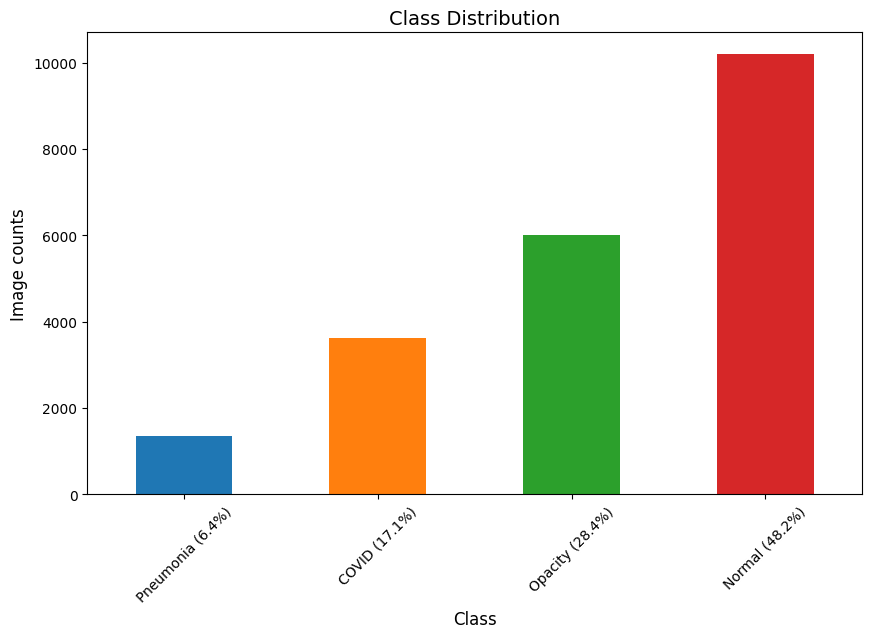

In [ ]:
#---class distribution---

# Count the occurrences of each category
df = pd.read_csv(path_merged_csv, encoding='utf-8')
cls_cnts = df['category'].value_counts().sort_values(ascending=True)


# Compute total and fractions
total = cls_cnts.sum()
cls_cnts.index = [f"{label} ({value / total:.1%})" for label, value in cls_cnts.items()]


# Plotting the countplot
plt.figure(figsize=(10, 6))

cls_cnts.plot(kind='bar', color=list(plt.cm.tab10.colors[:len(cls_cnts)]))

# Adding labels and title
plt.title("Class Distribution", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Image counts", fontsize=12)
plt.xticks(rotation=45)

plt.show()

In [22]:
# ---- show some samples from the merged metadata file randomly -----
df_m = pd.read_csv(path_merged_csv)
df_sapml=df_m.sample(n=15, random_state=110).drop(columns=['category'])
df_sapml.to_csv(os.path.join(METADATA_DIR, "sampled_metadata.csv"), index=False)
df_sapml

,file name,format,size,url,detected_resolution,channels
18970,Normal-9343,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...,299x299,RGB
2345,COVID-2346,PNG,256*256,https://bimcv.cipf.es/bimcv-projects/bimcv-cov...,299x299,RGB
8157,Lung_Opacity-4542,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,299x299,RGB
9259,Lung_Opacity-5644,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,299x299,RGB
15893,Normal-6266,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,299x299,RGB
1030,COVID-1031,PNG,256*256,https://github.com/ieee8023/covid-chestxray-da...,299x299,RGB
413,COVID-414,PNG,256*256,https://eurorad.org,299x299,RGB
19862,Viral Pneumonia-43,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...,299x299,RGB
21070,Viral Pneumonia-1251,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...,299x299,RGB
13992,Normal-4365,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...,299x299,RGB


## Summary of metadata exploration

In [ ]:
#---list unique values in the merged metadata file ----

display(df_m.groupby(["url", 'category']).count())

print("""
Metadata Summary:
----------------------------
COVID: 6 independent sources
Pneumonia + Normal: 1 independent source
Opacity + Normal: 1 independent source

All images have RGB channels with 299x299 detected resolution -> in original .xls files the resolution is given by 256x256 
Each pixel has the same value for each RGB channel -> greyscale images

Provided image-lung-masks have the detected resolution of 256x256 
""")

file name  \
url                                                category               
https://bimcv.cipf.es/bimcv-projects/bimcv-covi... COVID           2474   
https://eurorad.org                                COVID            258   
https://github.com/armiro/COVID-CXNet              COVID            400   
https://github.com/ieee8023/covid-chestxray-dat... COVID            182   
https://github.com/ml-workgroup/covid-19-image-... COVID            183   
https://sirm.org/category/senza-categoria/covid... COVID            119   
https://www.kaggle.com/c/rsna-pneumonia-detecti... Normal          8851   
                                                   Opacity         6012   
https://www.kaggle.com/paultimothymooney/chest-... Normal          1341   
                                                   Pneumonia       1345   

                                                              format  size  \
url                                                category                  
https://bimcv.cipf.es/bimcv-projects/bimcv-covi... COVID        2474  2474   
https://eurorad.org                                COVID         258   258   
https://github.com/armiro/COVID-CXNet              COVID         400   400   
https://github.com/ieee8023/covid-chestxray-dat... COVID         182   182   
https://github.com/ml-workgroup/covid-19-image-... COVID         183   183   
https://sirm.org/category/senza-categoria/covid... COVID         119   119   
https://www.kaggle.com/c/rsna-pneumonia-detecti... Normal       8851  8851   
                                                   Opacity      6012  6012   
https://www.kaggle.com/paultimothymooney/chest-... Normal       1341  1341   
                                                   Pneumonia    1345  1345   

                                                              detected_resolution  \
url                                                category                         
https://bimcv.cipf.es/bimcv-projects/bimcv-covi... COVID                     2474   
https://eurorad.org                                COVID                      258   
https://github.com/armiro/COVID-CXNet              COVID                      400   
https://github.com/ieee8023/covid-chestxray-dat... COVID                      182   
https://github.com/ml-workgroup/covid-19-image-... COVID                      183   
https://sirm.org/category/senza-categoria/covid... COVID                      119   
https://www.kaggle.com/c/rsna-pneumonia-detecti... Normal                    8851   
                                                   Opacity                   6012   
https://www.kaggle.com/paultimothymooney/chest-... Normal                    1341   
                                                   Pneumonia                 1345   

                                                              channels  
url                                                category             
https://bimcv.cipf.es/bimcv-projects/bimcv-covi... COVID          2474  
https://eurorad.org                                COVID           258  
https://github.com/armiro/COVID-CXNet              COVID           400  
https://github.com/ieee8023/covid-chestxray-dat... COVID           182  
https://github.com/ml-workgroup/covid-19-image-... COVID           183  
https://sirm.org/category/senza-categoria/covid... COVID           119  
https://www.kaggle.com/c/rsna-pneumonia-detecti... Normal         8851  
                                                   Opacity        6012  
https://www.kaggle.com/paultimothymooney/chest-... Normal         1341  
                                                   Pneumonia      1345


Metadata Summary:
----------------------------
COVID: 6 independent sources
Pneumonia + Normal: 1 independent source
Opacity + Normal: 1 independent source

All images have RGB channels with 299x299 resolution -> in original data 256x256 resolution
Each pixel has the same value for each RGB channel -> greyscale images

Provided image-lung-masks have the resolution of 256x256 



# 